In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from run_map import read_dask, map_mean, map_msc, map_trend, map_anomalies, map_err
from run_upscaling_xarr import load_ds
from datetime import datetime

In [2]:
pred_id = '14246832_2022110313584614'
repetitions = range(0, 30)
# change date range here
time_range = (datetime.strptime('01-2001', '%m-%Y'), datetime.strptime('01-2020', '%m-%Y'))
pred_ids = [pred_id + '_' + str(ii) for ii in repetitions]
pred_dir = 'predictions/{year}/{pred_id}'

In [3]:
# load predictions
data = read_dask(pred_dir, time_range, pred_ids, dims=('y', 'x', 'time'))
data = data.rename({'lat': 'y', 'lon': 'x'})
data['x'] = np.round(data['x'], decimals=3)
data['y'] = np.round(data['y'], decimals=3)
data

<xarray.Dataset>
Dimensions:  (rep: 30, time: 228, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-31 2001-02-28 ... 2019-12-31
  * lon      (lon) float64 -180.0 -179.7 -179.5 -179.2 ... 179.3 179.5 179.8
  * lat      (lat) float64 -89.97 -89.72 -89.47 -89.22 ... 89.28 89.53 89.78
Dimensions without coordinates: rep
Data variables:
    GPP      (rep, time, lat, lon) float32 dask.array<chunksize=(1, 12, 720, 1440), meta=np.ndarray>
Range:
(datetime.datetime(2001, 1, 1, 0, 0), datetime.datetime(2020, 1, 1, 0, 0))
<xarray.Dataset>
Dimensions:  (rep: 30, time: 228, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-31 2001-02-28 ... 2019-12-31
  * lon      (lon) float64 -180.0 -179.7 -179.5 -179.2 ... 179.3 179.5 179.8
  * lat      (lat) float64 -89.97 -89.72 -89.47 -89.22 ... 89.28 89.53 89.78
Dimensions without coordinates: rep
Data variables:
    GPP      (rep, time, lat, lon) float32 dask.array<chunksize=(1, 12, 720, 1440), meta=np

,Array,Chunk
Bytes,26.42 GiB,3.96 MiB
Shape,"(228, 30, 720, 1440)","(1, 1, 720, 1440)"
Count,37050 Tasks,6840 Chunks
Type,float32,numpy.ndarray


In [4]:
# load LC
lc = []
# change date range here
for year in range(2001, 2020):
    for month in range(1, 13):
        lc.append(load_ds(year, month, {'MCD12Q1':['IGBP']}))
        
lc = xr.concat(lc, dim='time')

# resample lc to same size as prediction
lc = lc.sortby('y', ascending=True)
lc = lc.isel(x=slice(0, None, 5), y=slice(0, None, 5))
lc = lc.drop(['spatial_ref']).squeeze()

lc

/global/scratch/users/maxgaber/envs/_map/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.Dataset>
Dimensions:  (time: 228, y: 720, x: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-31 2001-02-28 ... 2019-12-31
  * x        (x) float64 -180.0 -179.7 -179.5 -179.2 ... 179.0 179.3 179.5 179.8
  * y        (y) float64 -89.97 -89.72 -89.47 -89.22 ... 89.03 89.28 89.53 89.78
Data variables:
    IGBP     (time, y, x) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes:
    add_offset:    0.0
    long_name:     IGBP
    scale_factor:  1.0

In [5]:
# calc relative average standard error
err_relat = (data.std(dim='rep') / ((data.count(dim='rep')**0.5 * data.mean(dim='rep'))**2)**0.5).rename({'GPP': 'GPP_err'})

In [6]:
data_combined = xr.combine_by_coords([data.GPP.mean(dim='rep'), err_relat.GPP_err, lc.IGBP])
data_combined

<xarray.Dataset>
Dimensions:  (x: 1440, y: 720, time: 228)
Coordinates:
  * x        (x) float64 -180.0 -179.7 -179.5 -179.2 ... 179.0 179.3 179.5 179.8
  * y        (y) float64 -89.97 -89.72 -89.47 -89.22 ... 89.03 89.28 89.53 89.78
  * time     (time) datetime64[ns] 2001-01-31 2001-02-28 ... 2019-12-31
Data variables:
    GPP      (time, y, x) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    GPP_err  (time, y, x) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    IGBP     (time, y, x) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

In [7]:
data_combined['IGBP'] = data_combined.IGBP.fillna(0).astype(int)
grps2 = data_combined.groupby('IGBP')
grps2 = list(grps2)

In [8]:
lc_errs = {
    #'NAN': grps2[0][1].GPP_err, # not included
    'ENF': grps2[1][1].GPP_err, 
    'EBF': grps2[2][1].GPP_err, 
    #'DNF': grps2[3][1].GPP_err, # not included?
    'DBF': grps2[4][1].GPP_err, 
    'MF': grps2[5][1].GPP_err, 
    'SH': xr.concat([grps2[6][1].GPP_err, grps2[7][1].GPP_err], dim='stacked_time_y_x'), 
    'SAV': xr.concat([grps2[8][1].GPP_err, grps2[9][1].GPP_err], dim='stacked_time_y_x'), 
    'GRA': grps2[10][1].GPP_err, 
    'WET': grps2[11][1].GPP_err, 
    'CRO': grps2[12][1].GPP_err, 
    #'URB': grps2[13][1].GPP_err, # not included
    #'CVM': grps2[14][1].GPP_err, # not included
    #'SNO': grps2[15][1].GPP_err, # not included
    #'BSV': grps2[16][1].GPP_err, # not included
    #'WAT': grps2[17][1].GPP_err  # not included
}

#gpp_vals = {
#    'NAN': grps2[0][1].GPP, # not included
#    'ENF': grps2[1][1].GPP, 
#    'EBF': grps2[2][1].GPP, 
#    'DNF': grps2[3][1].GPP, # not included?
#    'DBF': grps2[4][1].GPP, 
#    'MF': grps2[5][1].GPP, 
#    'SH': xr.concat([grps2[6][1].GPP, grps2[7][1].GPP], dim='stacked_time_y_x'), 
#    'SAV': xr.concat([grps2[8][1].GPP, grps2[9][1].GPP], dim='stacked_time_y_x'), 
#    'GRA': grps2[10][1].GPP, 
#    'WET': grps2[11][1].GPP, 
#    'CRO': grps2[12][1].GPP, 
#    'URB': grps2[13][1].GPP, # not included
#    'CVM': grps2[14][1].GPP, # not included
#    'SNO': grps2[15][1].GPP, # not included
#    'BSV': grps2[16][1].GPP, # not included
#    'WAT': grps2[17][1].GPP  # not included
#}

In [9]:
# save lc errs
import pandas as pd

#import dask.dataframe as dd
#ddf = dd.from_pandas(pd.DataFrame(columns=['key', 'value']))

# Iterate through the dictionary and append data to Dask DataFrame
#for key, xarr in data_dict.items():
#    df = pd.DataFrame({'key': [key] * len(xarr), 'value': xarr.values})
#    ddf = ddf.append(df, ignore_index=True)
    
#ddf.to_csv('analysis/lc_errs.csv', single_file=True)

key_list = []
value_list = []

for key, xarr in lc_errs.items():
    print(key)
    key_list.extend([key] * len(xarr))
    value_list.extend(xarr.values)

# Create a pandas DataFrame
lc_errs_df = pd.DataFrame({'key': key_list, 'value': value_list})

lc_errs_df.to_csv('analysis/lc_errs.csv')

ENF


/global/scratch/users/maxgaber/envs/_map/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


EBF
DBF
MF
SH
SAV
GRA
WET
CRO


In [9]:
def draw_hist(x_vals, 
              n_bins, 
              rng=None, 
              x_fit=None, 
              fit_func=None,
              fit_params={},
              fit_scale=False,
              errs=False, 
              density=False,
              fit_info=None,
              ax=None, 
              fit_color='red', 
              hist_color='black',
              hist_alpha=1,
              fit_label='Fitted curve',
              hist_label='Histogram',
              x_label='Value',
              legend=True, 
              **kwargs):
    '''Draws a histogram

    Args:
        x_vals (array): Values to be binned
        n_bins (int): Number of bins
        rng (tuple): Minimum and maximum x value
        x_fit (array): Array of fitted x values
        fit_func (array): Fitting function
        fit_params (dict): Fitting parameters
        errs (bool): Errorbars on histogram
        fit_info (list): List of fit info for chart legend
        ax (matplotlib.axis): Axis object

    Returns:
        matplotlib axis object

    TODO:
        scaling factor N?
    '''
    plot = False
    if ax is None:
        plot = True
        fig, ax = plt.subplots(figsize=(10, 5))

    # histogram
    n_hist, x_loc, _ = ax.hist(x_vals, bins=n_bins, range=rng, density=density, label=hist_label, color=hist_color, histtype='step', alpha=hist_alpha, linewidth=1.5)

    print(np.sum(n_hist))

    # normalize with N_points * binwidth
    # binwidth = (xmax - xmin) / n_bins
    binwidth = np.abs(np.max(x_loc) - np.min(x_loc[0]))/n_bins
    #binwidth = np.abs(x_loc[1] - x_loc[0])
    n_points = len(x_vals)
    N = n_points * binwidth
    x_loc = (x_loc + binwidth/2)[:-1]

    # plot scatter and error bars
    if errs:
        ax.errorbar(x_loc, n_hist, yerr=np.sqrt(n_hist * (binwidth**(density))), ls='None', capsize=3, color=hist_color)

    # curve
    if fit_func is not None:
        if x_fit is None:
            x_fit = np.linspace(x_loc[0], x_loc[-1], 1000)

        ax.plot(x_fit, (fit_scale * N + 1 - fit_scale) * fit_func(x_fit, **fit_params), label=fit_label, color=fit_color)
    if density:
        ylabel = 'Density'
    else:
        ylabel = 'Frequency'

    ax.set(xlabel=x_label, ylabel=ylabel + " / " + str(np.around(binwidth, 4)), **kwargs)

    if legend:
        leg_title = ''
        if fit_info is not None:
            leg_title = "\n".join(fit_info)
        ax.legend(title=leg_title, loc=4, ncol=2)

    if plot == False:
        return ax
    else:
        plt.show()

/global/scratch/users/maxgaber/envs/_map/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


2000.0
1999.9999999999995
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0


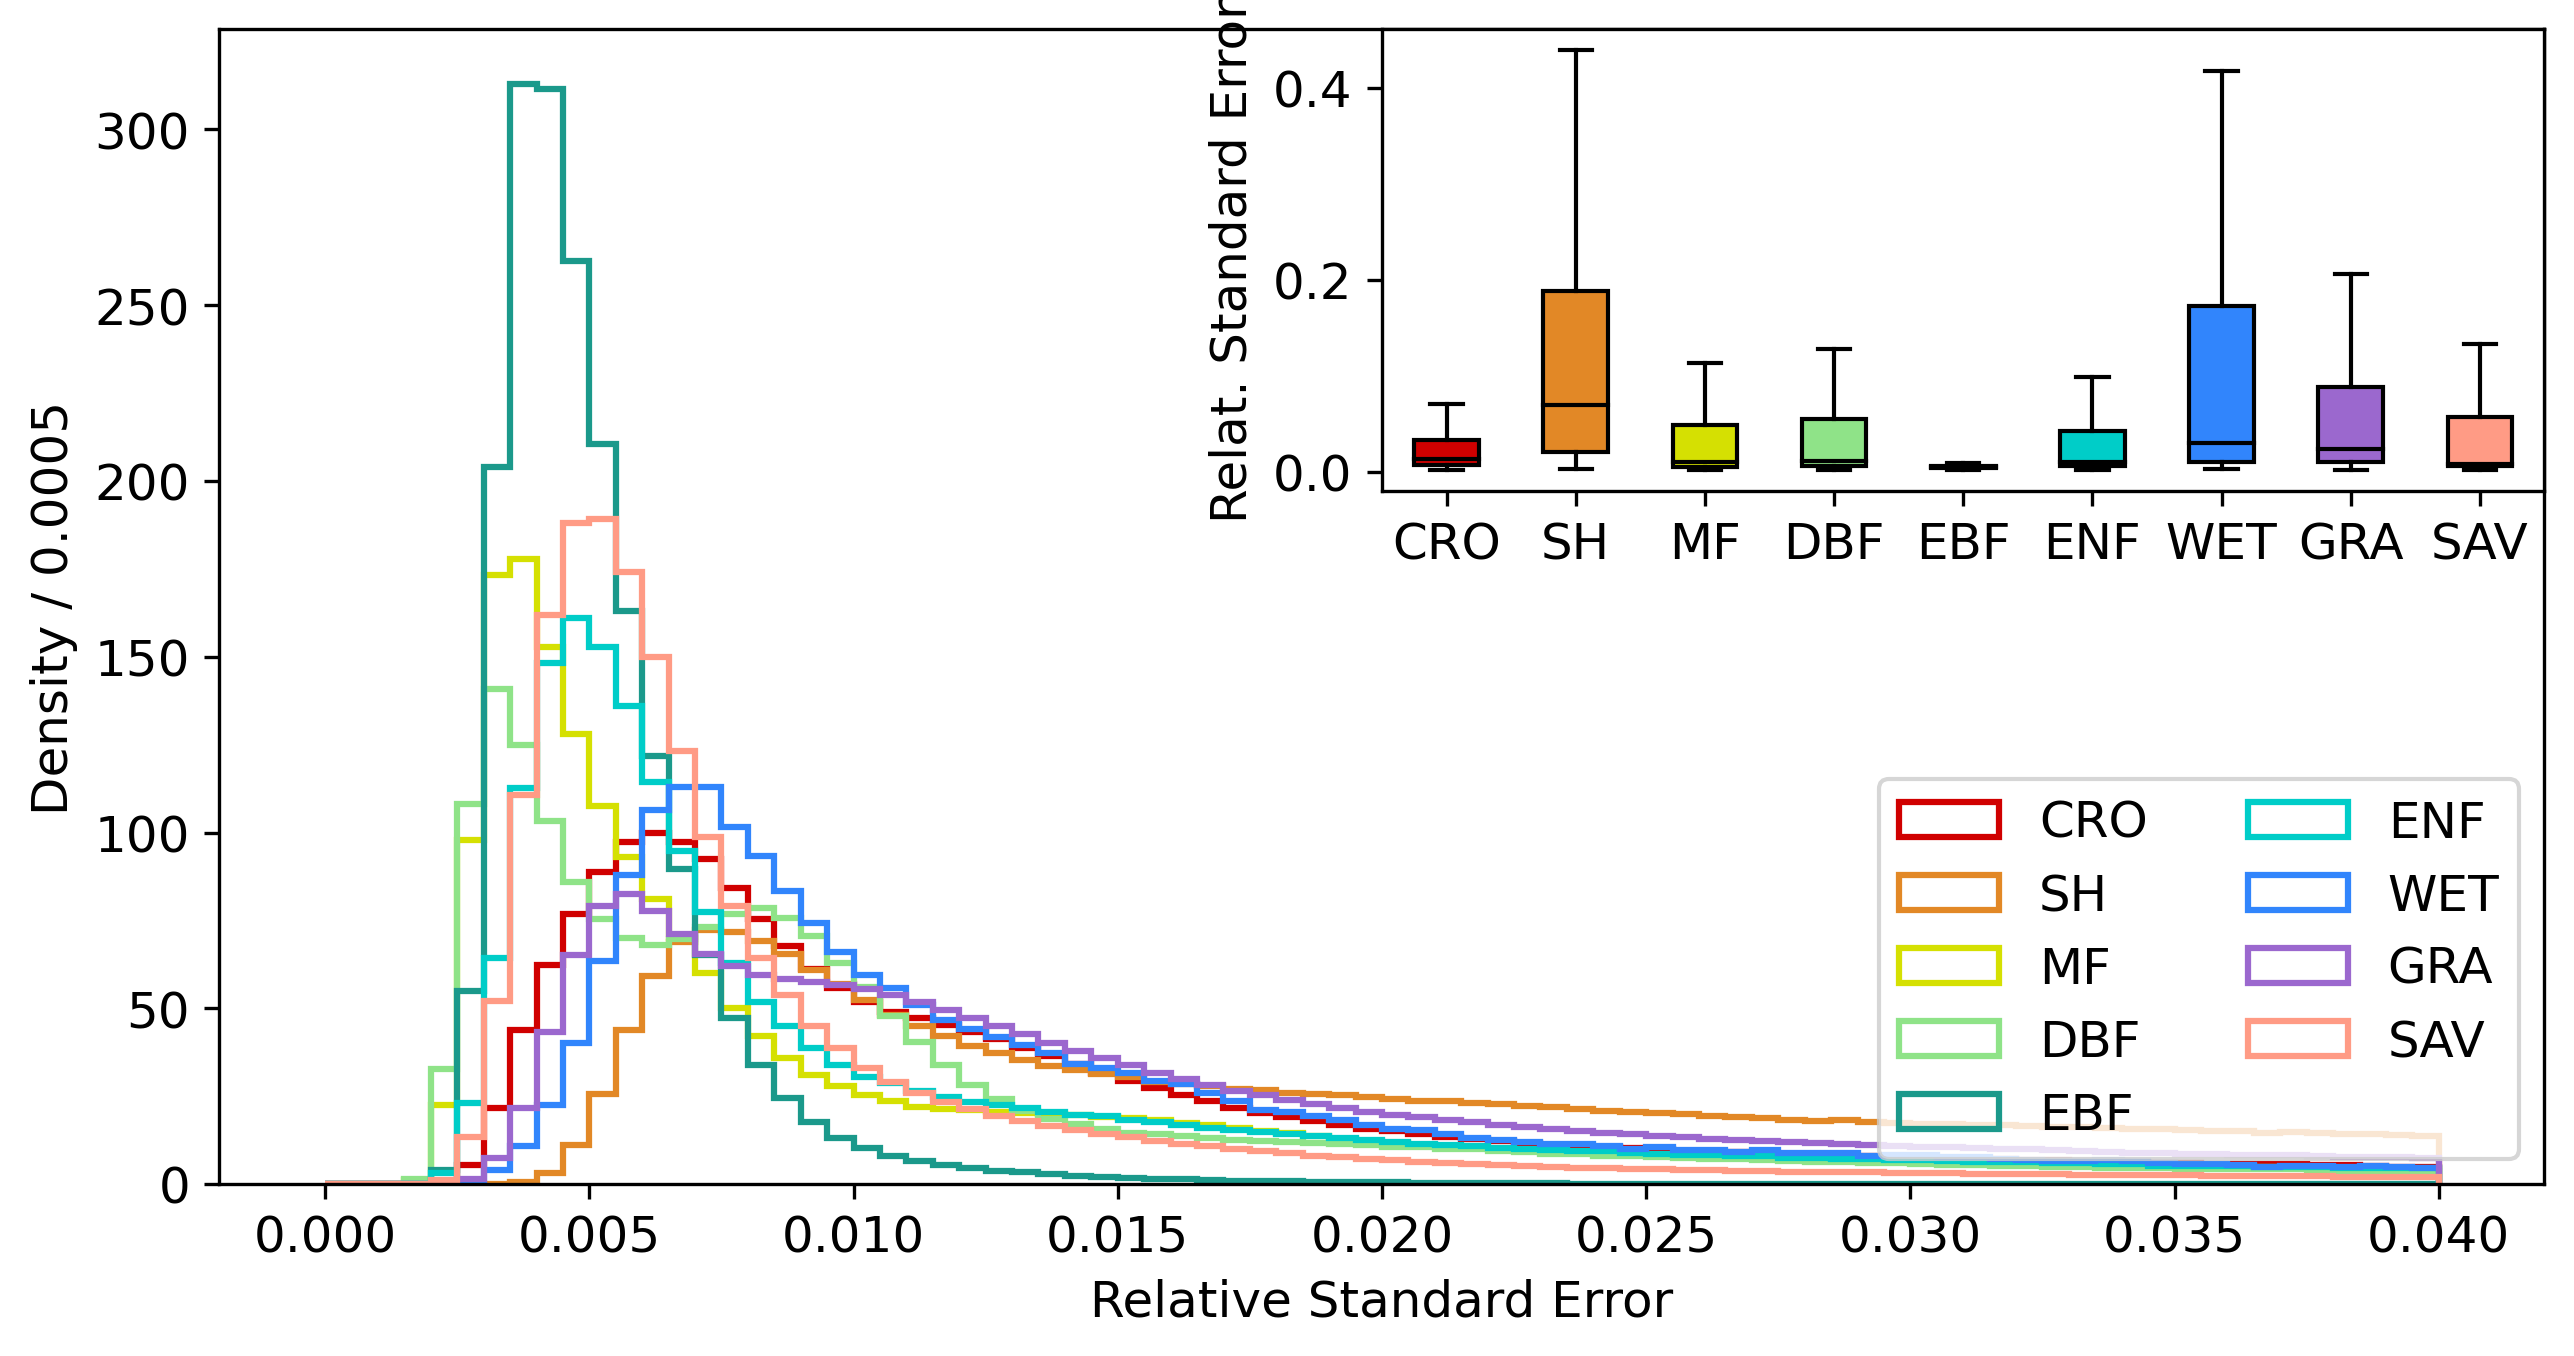

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
bins = 80
rng = (0, .04)
draw_hist(lc_errs['CRO'], bins, ax=ax, density=True, fit_scale=True, rng=rng, hist_label='CRO', hist_color='#D00000')
draw_hist(lc_errs['SH'], bins, ax=ax, density=True, fit_scale=True, rng=rng, hist_label='SH', hist_color='#E28826')
draw_hist(lc_errs['MF'], bins, ax=ax, density=True, fit_scale=True, rng=rng, hist_label='MF', hist_color='#D5E002')
draw_hist(lc_errs['DBF'], bins, ax=ax, density=True, fit_scale=True, rng=rng, hist_label='DBF', hist_color='#8FE388')
draw_hist(lc_errs['EBF'], bins, ax=ax, density=True, fit_scale=True, rng=rng, hist_label='EBF', hist_color='#1B998B')
draw_hist(lc_errs['ENF'], bins, ax=ax, density=True, fit_scale=True, rng=rng, hist_label='ENF', hist_color='#00CDC8')
draw_hist(lc_errs['WET'], bins, ax=ax, density=True, fit_scale=True, rng=rng, hist_label='WET', hist_color='#3185FC')
draw_hist(lc_errs['GRA'], bins, ax=ax, density=True, fit_scale=True, rng=rng, hist_label='GRA', hist_color='#9B68CE')
draw_hist(lc_errs['SAV'], bins, ax=ax, density=True, fit_scale=True, rng=rng, hist_label='SAV', hist_color='#FF9B85', x_label='Relative Standard Error')

ax_inset = ax.inset_axes([0.5, 0.6, 0.5, 0.4])
keys = ['CRO', 'SH', 'MF', 'DBF', 'EBF', 'ENF', 'WET', 'GRA', 'SAV']
colors = ['#D00000', '#E28826', '#D5E002', '#8FE388', '#1B998B', '#00CDC8', '#3185FC', '#9B68CE', '#FF9B85']
data = [lc_errs[x] for x in keys]
boxplot = ax_inset.boxplot(data, patch_artist=True, labels=keys, showfliers=False, medianprops={'color': 'black'})

for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)
ax_inset.set_ylabel('Relat. SEM')

plt.savefig('hist3.pdf')